In [27]:
from src.models import Exponential_Model
from src.criterion import right_censored,RightCensorWrapper
from src.load_data import load_datasets,load_dataframe
from src.utils import train_robust,lower_bound
from src.visualizations import visualize_population_curves_attacked,visualize_individual_curves_attacked,visualize_individual_curves_changes
from src.metrics import concordance

from torch.optim import Adam
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter

from auto_LiRPA import BoundedModule, BoundedTensor

from tqdm import tqdm
import pandas as pd
import numpy as np
from copy import deepcopy

In [28]:
class ARGS(object):
    def __init__(self):
        pass

In [36]:
args = ARGS()
args.verify=False
args.device="cpu"

args.seed = 123

args.eps=0.5
args.norm=np.inf
args.bound_type = "CROWN-IBP"
args.num_epochs=10
args.lr = 1e-3
args.batch_size= 128
args.scheduler_name = "SmoothedScheduler"
args.scheduler_opts = "start=5,length=20"
args.hidden_dims = [15,15]
args.save_model = ""
args.dataset = "Dialysis"


In [37]:
# GOOD DATASETS
# 1. TRACE
# 2. divorce 
# 3. Dialysis
dataset_train,dataset_test = load_datasets(args.dataset,test_size=0.2)

In [38]:
input_dims = dataset_train.tensors[0].shape[1]
output_dim = 1

In [39]:
dataloader_train = DataLoader(dataset_train,batch_size=args.batch_size,shuffle=True)
dataloader_test = DataLoader(dataset_test,batch_size=args.batch_size,shuffle=False)

dataloader_train.mean = dataloader_test.mean = dataset_train.mean
dataloader_train.std = dataloader_test.std = dataset_train.std


dataset_train.tensors[0].shape

torch.Size([5444, 74])

In [40]:
clf_robust = Exponential_Model(input_dim=input_dims,hidden_layers=args.hidden_dims)
clf_fragile = Exponential_Model(input_dim=input_dims,hidden_layers=args.hidden_dims)
clf_fragile.load_state_dict(deepcopy(clf_robust.state_dict()))


# # model = BoundedModule(clf, X_train)
# model_robust_wrap = BoundedModule(RightCensorWrapper(clf_robust),dataset_train.tensors)
# model_fragile_wrap = BoundedModule(RightCensorWrapper(clf_fragile),dataset_train.tensors)

<All keys matched successfully>

In [41]:
train_robust(clf_robust,dataloader_train,dataloader_test,method="robust",args=args)

C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\torch\optim\lr_scheduler.py:371: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 1, learning rate [0.001]
[ 1:   0]: eps=0.00000000 Loss=1344.4089 Time=0.0050
[ 1:  10]: eps=0.00000000 Loss=1331.0121 Time=0.0042
[ 1:  20]: eps=0.00000000 Loss=1250.2025 Time=0.0041
[ 1:  30]: eps=0.00000000 Loss=1211.6485 Time=0.0041
[ 1:  40]: eps=0.00000000 Loss=1139.4532 Time=0.0037
[ 1:  42]: eps=0.00000000 Loss=1125.1508 Time=0.0036
Epoch time: 0.2027, Total time: 0.2027
Evaluating...
[ 1:  10]: eps=0.00000000 Loss=799.0148 Time=0.0019
Epoch 2, learning rate [0.001]
[ 2:   0]: eps=0.00000000 Loss=689.5661 Time=0.0030
[ 2:  10]: eps=0.00000000 Loss=739.7616 Time=0.0029
[ 2:  20]: eps=0.00000000 Loss=671.4186 Time=0.0030
[ 2:  30]: eps=0.00000000 Loss=605.7960 Time=0.0033
[ 2:  40]: eps=0.00000000 Loss=549.0113 Time=0.0034
[ 2:  42]: eps=0.00000000 Loss=538.9581 Time=0.0034
Epoch time: 0.1921, Total time: 0.3949
Evaluating...
[ 2:  10]: eps=0.00000000 Loss=302.7602 Time=0.0016
Epoch 3, learning rate [0.001]
[ 3:   0]: eps=0.00000000 Loss=296.3044 Time=0.0031
[ 3:  10]: eps=

In [42]:
for i in clf_robust.parameters():
    print(i.requires_grad)

False
False
False
False
False
False


In [9]:
train_robust(clf_fragile,dataloader_train,dataloader_test,method="natural",args=args)

Epoch 1, learning rate [0.001]
[ 1:   0]: eps=0.00000000 Loss=1608.3944 Time=0.0045
[ 1:  10]: eps=0.00000000 Loss=1566.1577 Time=0.0033
[ 1:  20]: eps=0.00000000 Loss=1500.3828 Time=0.0030
[ 1:  30]: eps=0.00000000 Loss=1446.4680 Time=0.0030
[ 1:  40]: eps=0.00000000 Loss=1379.2705 Time=0.0032
[ 1:  42]: eps=0.00000000 Loss=1365.5821 Time=0.0033
Epoch time: 0.1817, Total time: 0.1817
Evaluating...
[ 1:  10]: eps=0.00000000 Loss=1043.3466 Time=0.0021
Epoch 2, learning rate [0.001]
[ 2:   0]: eps=0.00000000 Loss=1029.2239 Time=0.0050
[ 2:  10]: eps=0.00000000 Loss=1002.1197 Time=0.0036
[ 2:  20]: eps=0.00000000 Loss=938.6003 Time=0.0031
[ 2:  30]: eps=0.00000000 Loss=869.6247 Time=0.0030
[ 2:  40]: eps=0.00000000 Loss=796.9248 Time=0.0031
[ 2:  42]: eps=0.00000000 Loss=783.3200 Time=0.0031
Epoch time: 0.1819, Total time: 0.3636
Evaluating...
[ 2:  10]: eps=0.00000000 Loss=481.9359 Time=0.0018
Epoch 3, learning rate [0.001]
[ 3:   0]: eps=0.00000000 Loss=485.1701 Time=0.0030
[ 3:  10]: e

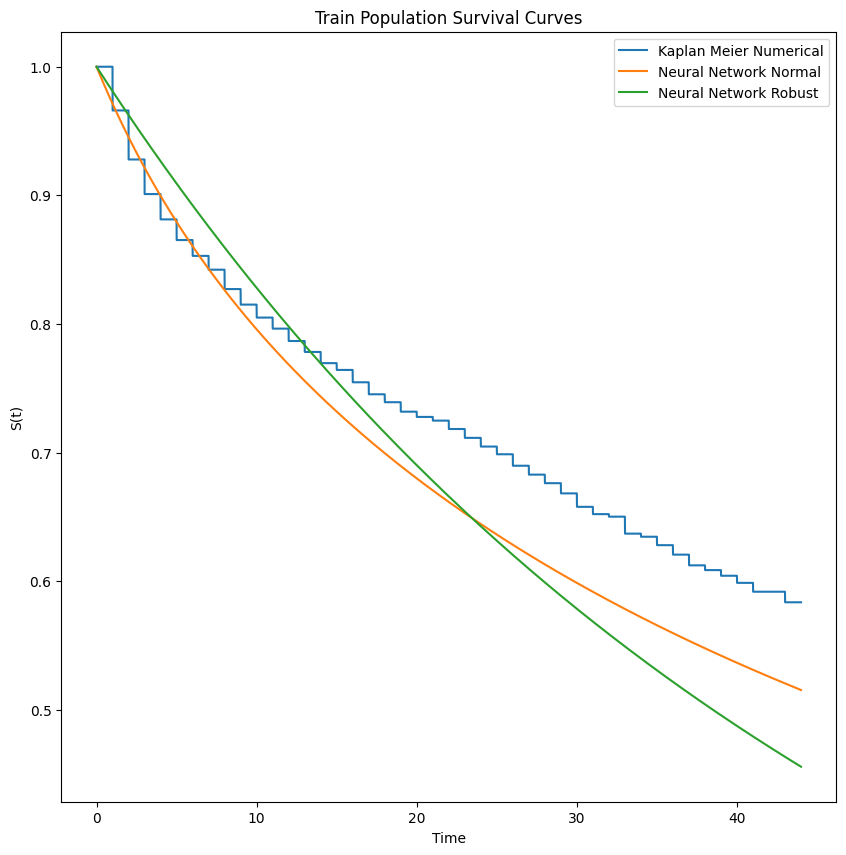

In [10]:
X_train,T_train,E_train = dataloader_train.dataset.tensors
t = torch.linspace(0,T_train.max(),10000)

St_robust_x = clf_robust.survival_qdf(X_train,t).detach()
St_fragile_x = clf_fragile.survival_qdf(X_train,t).detach()

kmf = KaplanMeierFitter()
kmf.fit(durations=T_train,event_observed=E_train)
St_kmf  = kmf.predict(times=t.ravel().numpy())

plt.figure(figsize=(10,10))
plt.plot(t,St_kmf)
plt.plot(t,St_fragile_x.mean(0))
plt.plot(t,St_robust_x.mean(0))

plt.ylabel("S(t)"); plt.xlabel("Time")
plt.legend(["Kaplan Meier Numerical","Neural Network Normal","Neural Network Robust"])
plt.title("Train Population Survival Curves")
plt.show()

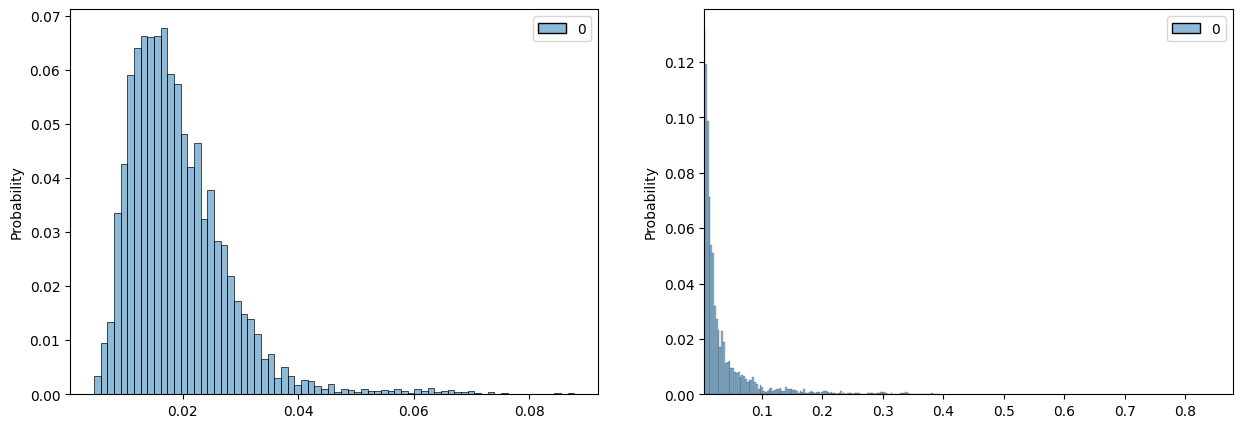

In [11]:
fig,axes = plt.subplots(1,2,figsize=(15,5))
lambda_robust = clf_robust(X_train).detach()
lambda_fragile = clf_fragile(X_train).detach()
sns.histplot(lambda_robust,ax=axes[0],stat="probability")
axes[1].set_xlim([lambda_robust.min(),lambda_robust.max()*10])
sns.histplot(lambda_fragile,ax=axes[1],stat="probability")
plt.show()

ROBUST CLF
CI @ eps=10 0.46140631179414265
CI @ eps=5 0.462380226408178
CI @ eps=2 0.5386432903433314
CI @ eps=1 0.6448489181173253
CI @ eps=0.8 0.6660846385961572
CI @ eps=0.7 0.6754784604386253
CI @ eps=0.6 0.6841748495364758
CI @ eps=0.5 0.6917032528770352
CI @ eps=0.1 0.7122436537067922
CI @ eps=0.07 0.7132786256604535
CI @ eps=0.05 0.7138987635944334
CI @ eps=0 0.7153269937501306
NONROBUST CLF


ValueError: NaNs detected in inputs, please correct or drop.

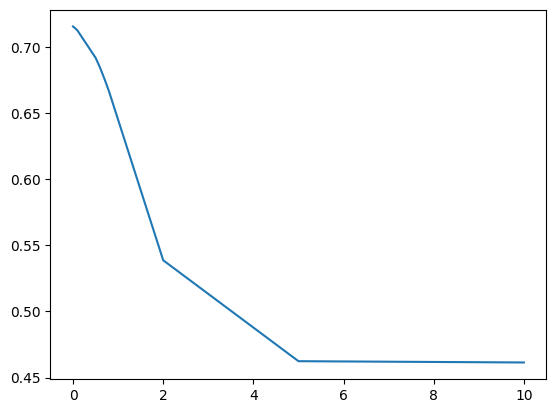

In [12]:
epsilons = [10,5,2,1,.8,0.7,.6,0.5,0.1,0.07,0.05,0]
print("ROBUST CLF")
eps_,ci_ = concordance(clf_robust,dataloader_train,epsilons)
plt.figure()
plt.plot(eps_,ci_)
print("NONROBUST CLF")
eps_,ci_ = concordance(clf_fragile,dataloader_train,epsilons)
plt.plot(eps_,ci_)
plt.legend(["Robust","Non Robust"])

tensor([0.0004, 0.0039, 0.0066, 0.0145, 0.0481, 0.0578, 0.0606, 0.0619, 0.0713,
        0.0752])


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.64it/s]


tensor([66.6058, 65.7206, 65.5267, 64.2287, 60.6126, 60.3545, 59.3413, 57.9569,
        57.1281, 56.9719])


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.70it/s]


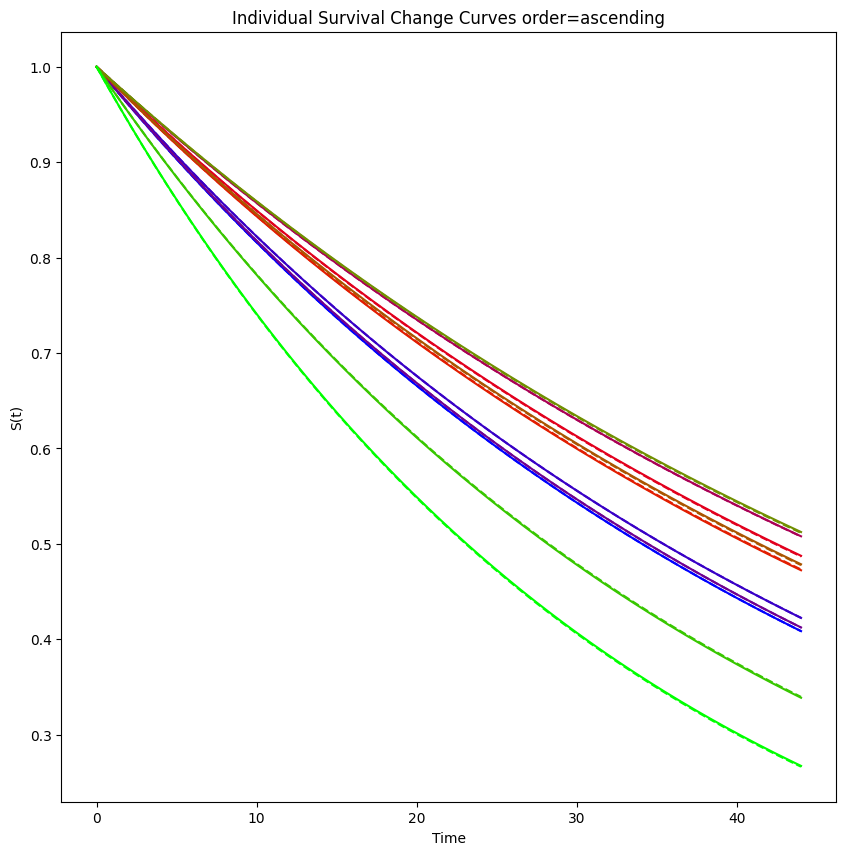

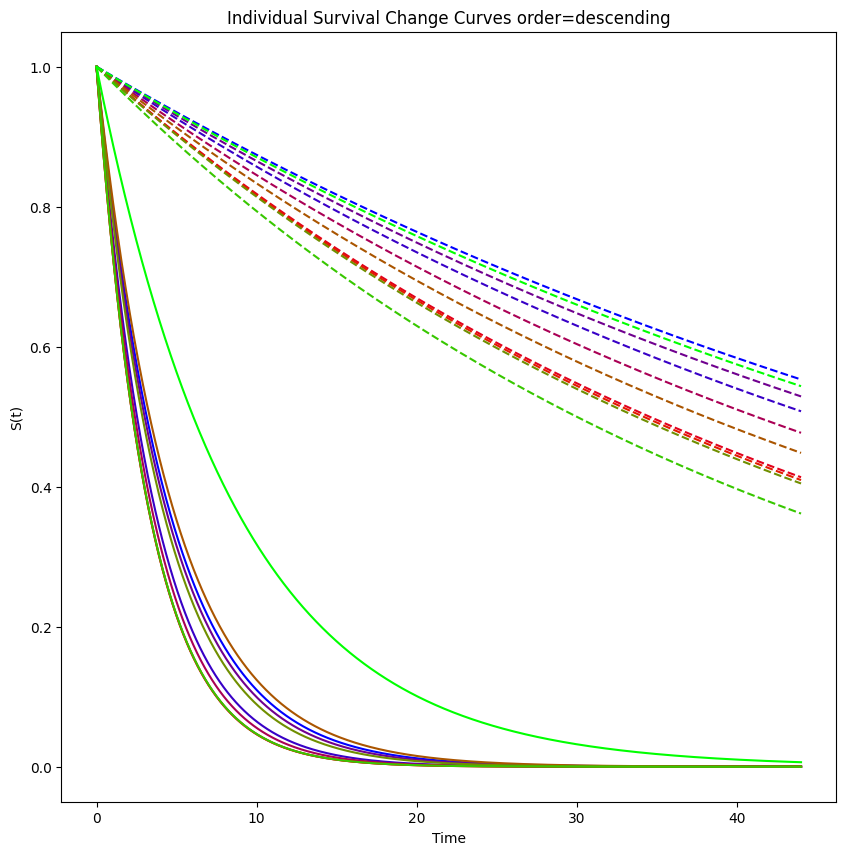

In [13]:
visualize_individual_curves_changes(clf_robust,clf_fragile,dataloader_train,order="ascending",test_cases=10)
visualize_individual_curves_changes(clf_robust,clf_fragile,dataloader_train,order="descending",test_cases=10)

tensor([0.0004, 0.0039, 0.0066, 0.0145, 0.0481, 0.0578, 0.0606, 0.0619, 0.0713,
        0.0752])


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.42it/s]


tensor([65.1898, 63.5625, 55.3265, 55.3257, 53.2035, 52.9825, 52.8662, 52.6539,
        52.0090, 51.2643])


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.63it/s]


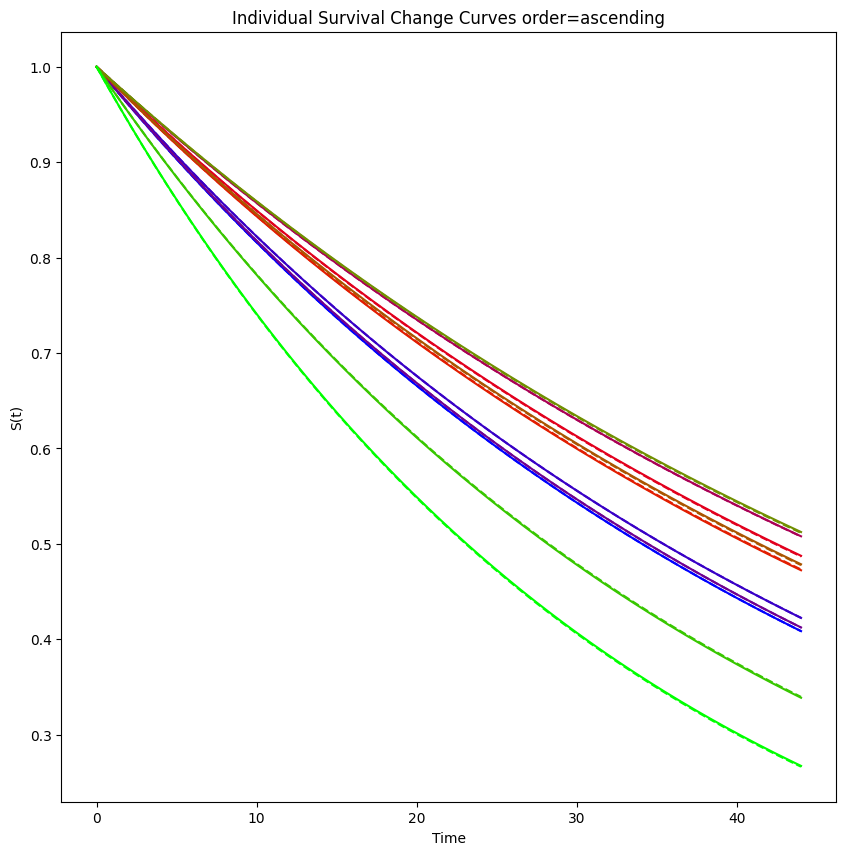

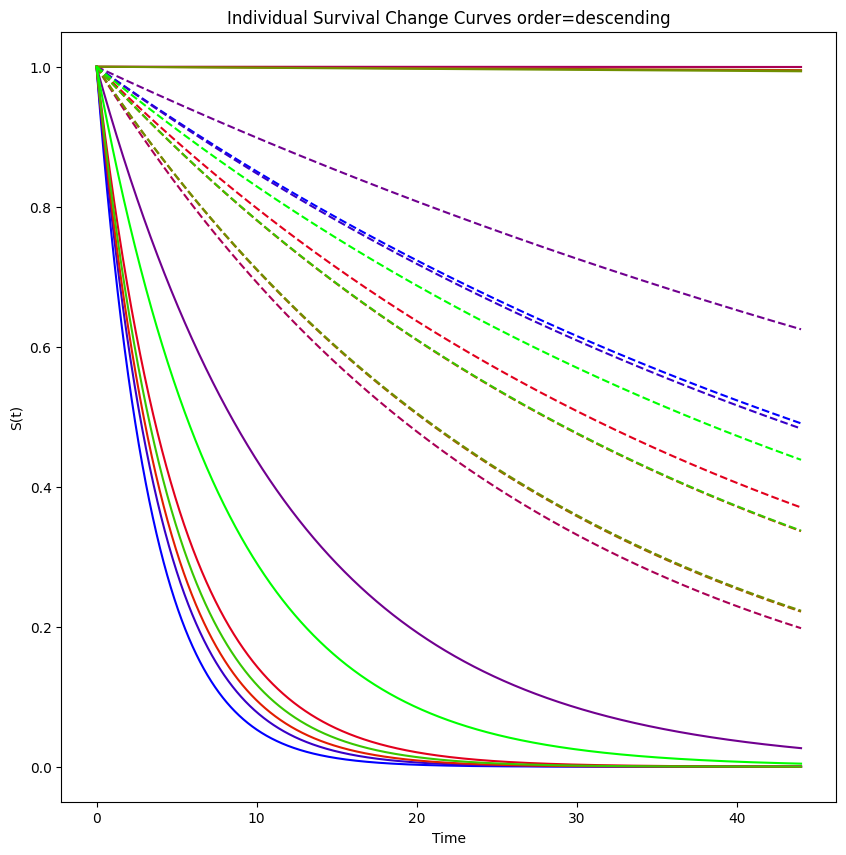

In [14]:
visualize_individual_curves_changes(clf_robust,clf_fragile,dataloader_train,order="ascending",test_cases=10)
visualize_individual_curves_changes(clf_robust,clf_fragile,dataloader_test,order="descending",test_cases=10)

<Figure size 1000x1000 with 0 Axes>

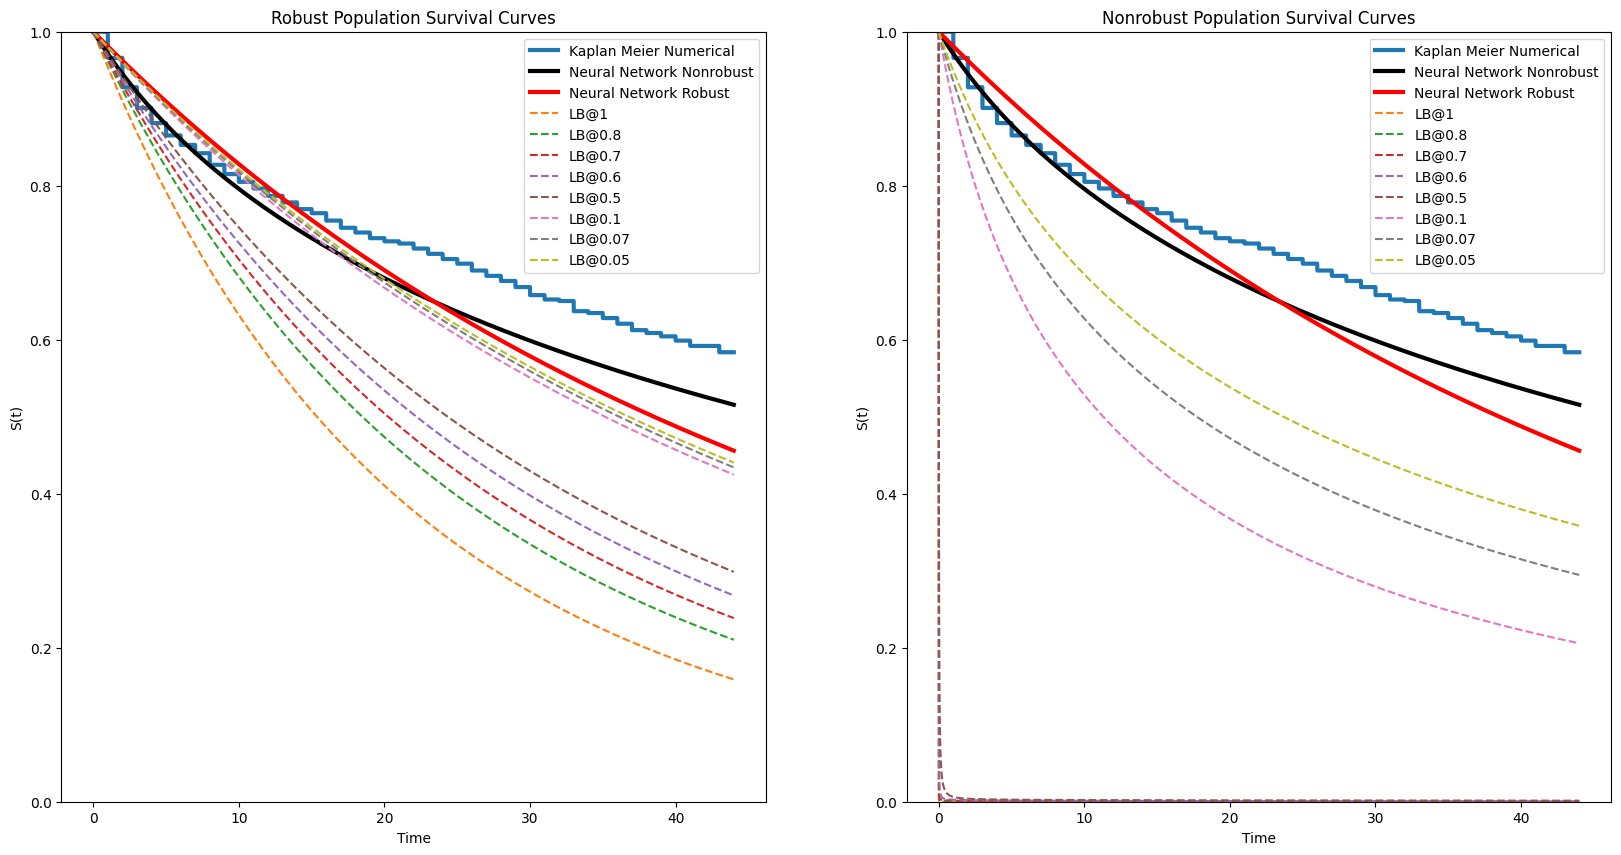

<Figure size 1000x1000 with 0 Axes>

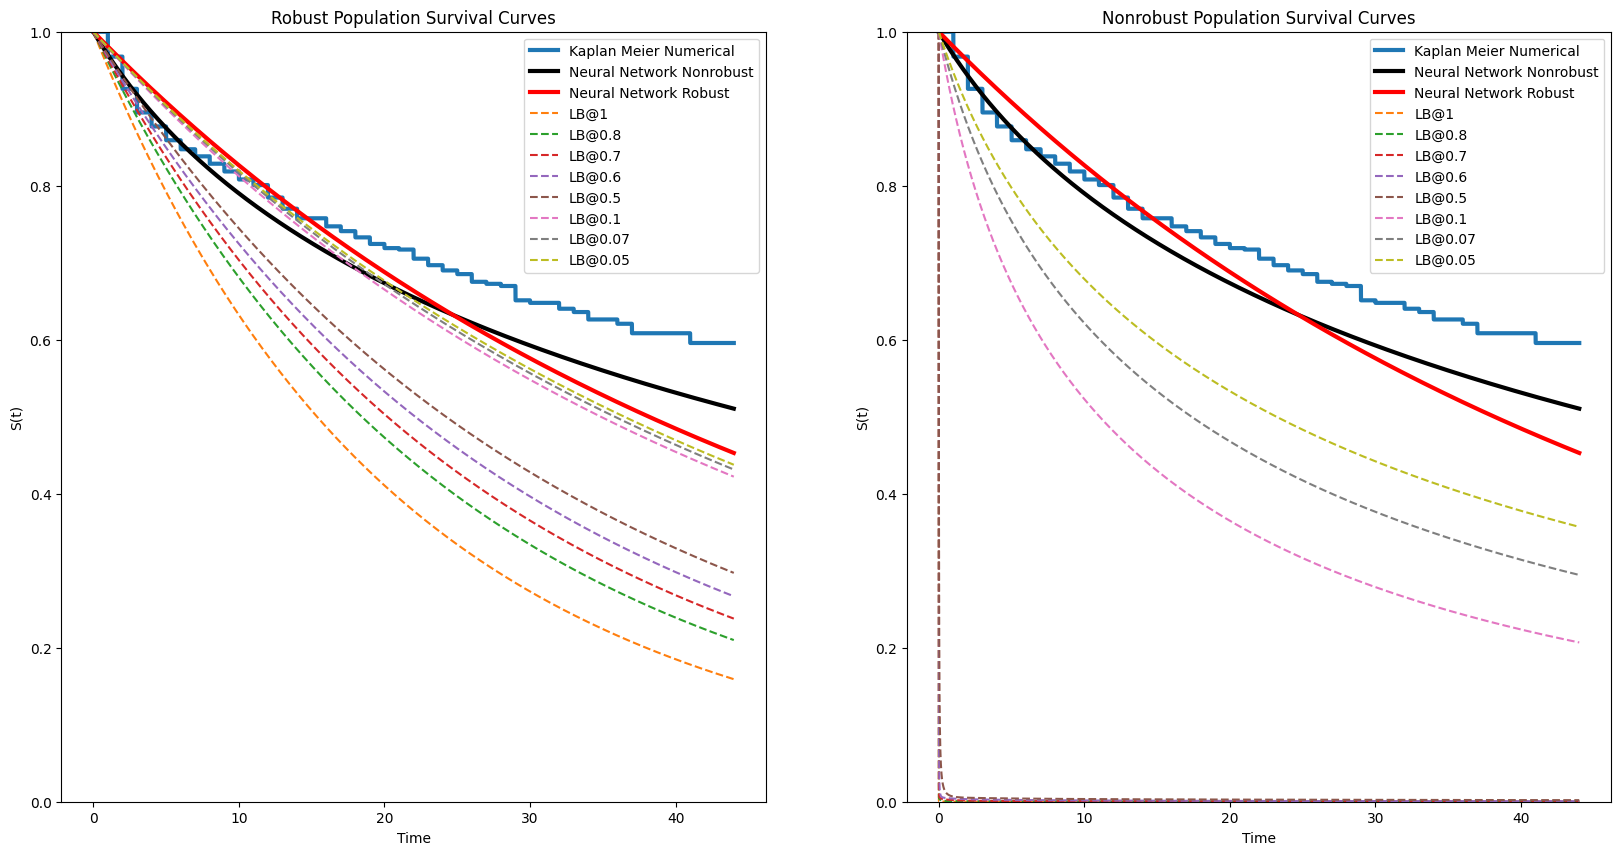

In [15]:
epsilons = [1,.8,0.7,.6,0.5,0.1,0.07,0.05]
visualize_population_curves_attacked(clf_fragile,clf_robust,dataloader_train,epsilons=epsilons)
visualize_population_curves_attacked(clf_fragile,clf_robust,dataloader_test,epsilons=epsilons)

<Figure size 1000x1000 with 0 Axes>

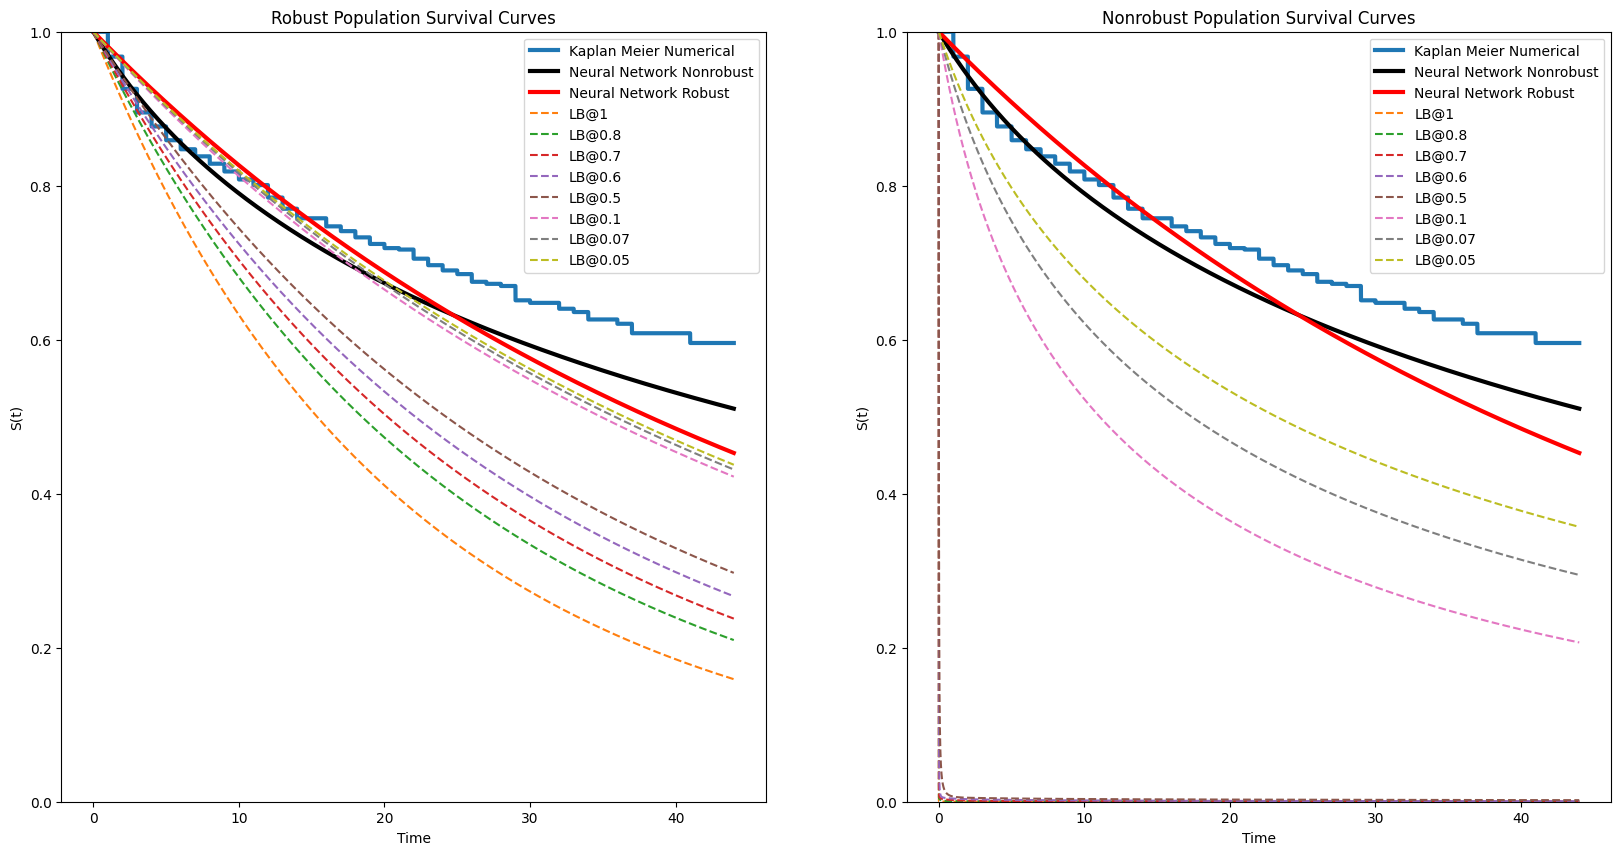

In [16]:
epsilons = [1,.8,0.7,.6,0.5,0.1,0.07,0.05]
visualize_population_curves_attacked(clf_fragile,clf_robust,dataloader_test,epsilons=epsilons)

tensor([12.9272, 12.7131, 12.5904, 12.5166, 12.4275, 12.3201, 12.2964, 12.2836,
        12.2607, 12.1379])


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.59it/s]


tensor([3.1427, 3.1494, 3.1861, 3.2097, 3.2463, 3.2608, 3.2924, 3.3075, 3.3368,
        3.3412])


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.71it/s]


tensor([11.9476, 11.8170, 11.7840, 11.7708, 11.7499, 11.7456, 11.7389, 11.7231,
        11.7157, 11.6461])


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.77it/s]


tensor([3.2805, 3.3221, 3.4257, 3.8077, 3.8176, 3.8484, 3.8762, 3.9438, 3.9493,
        3.9836])


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.56it/s]


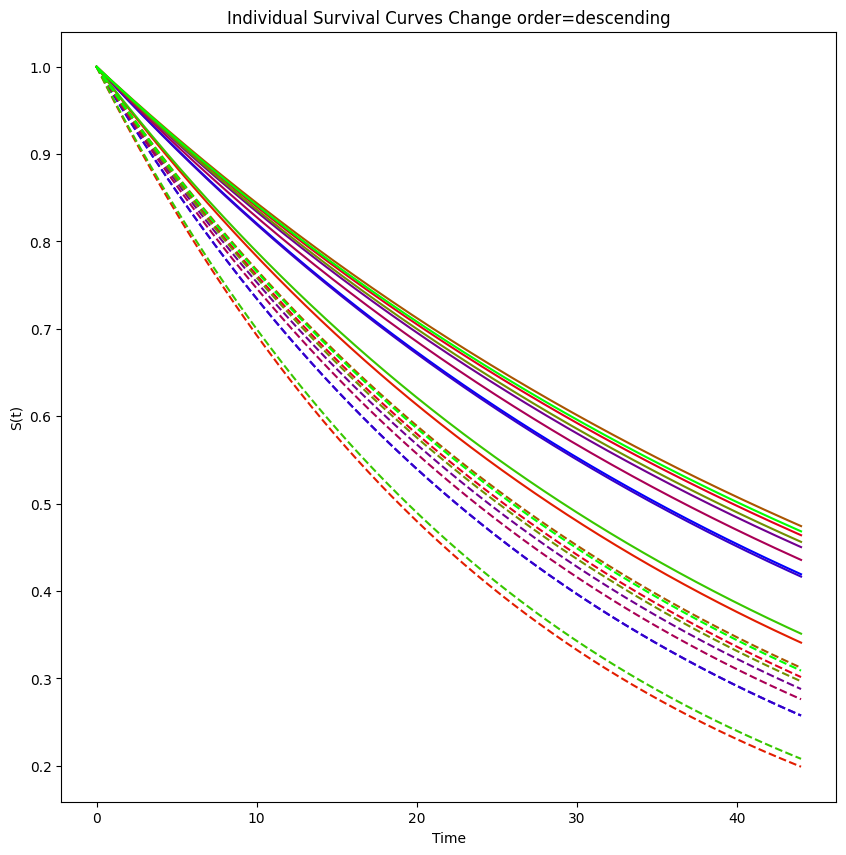

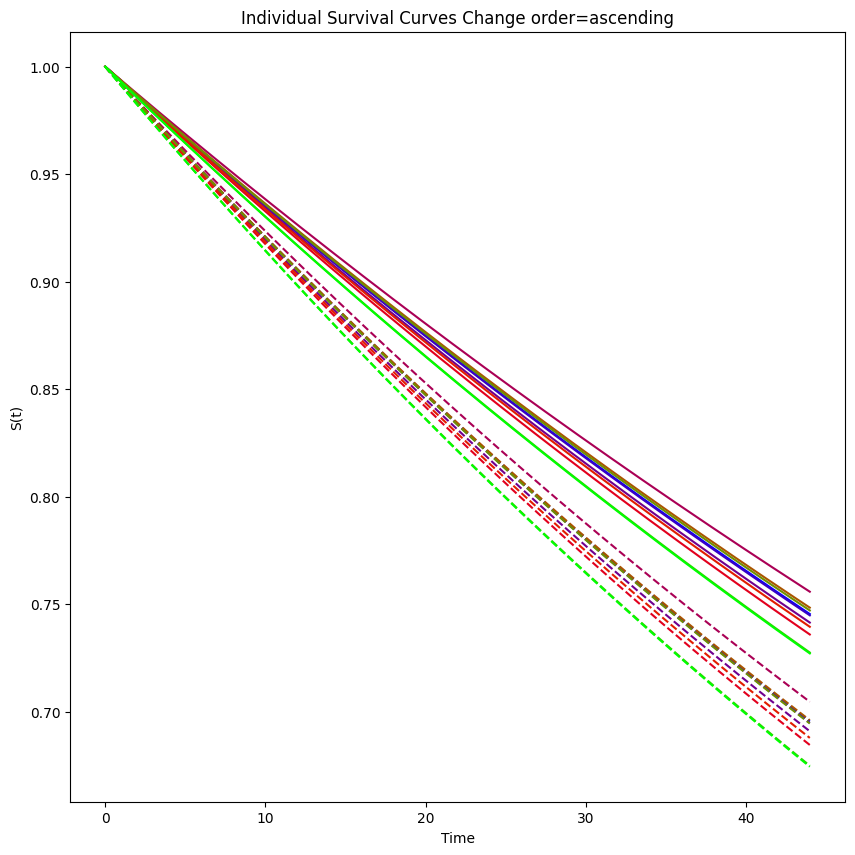

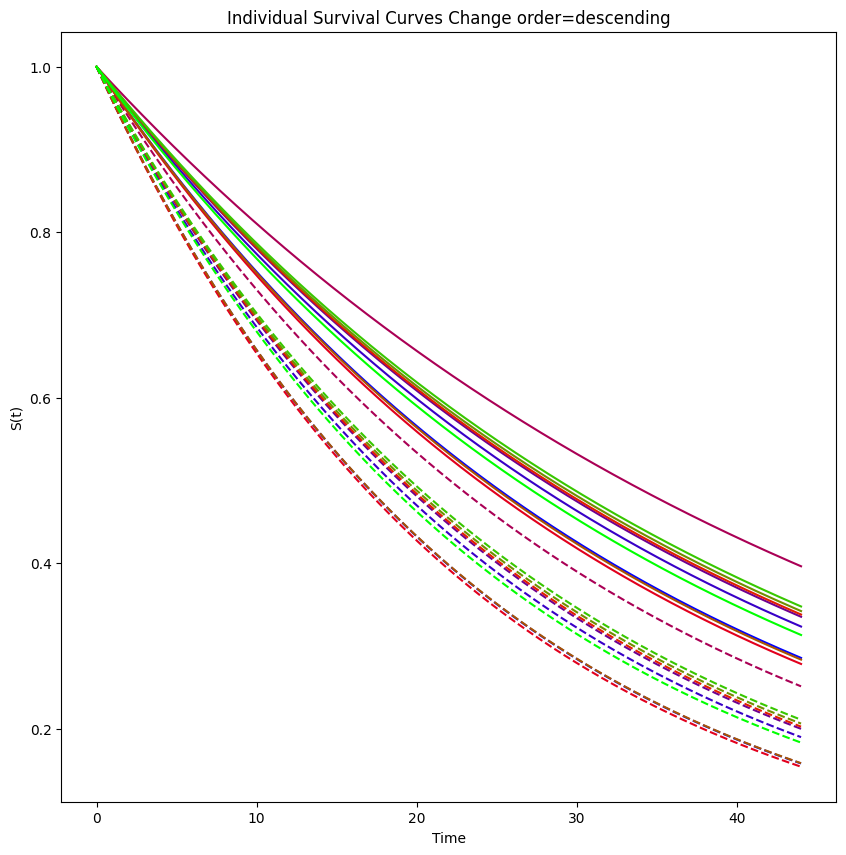

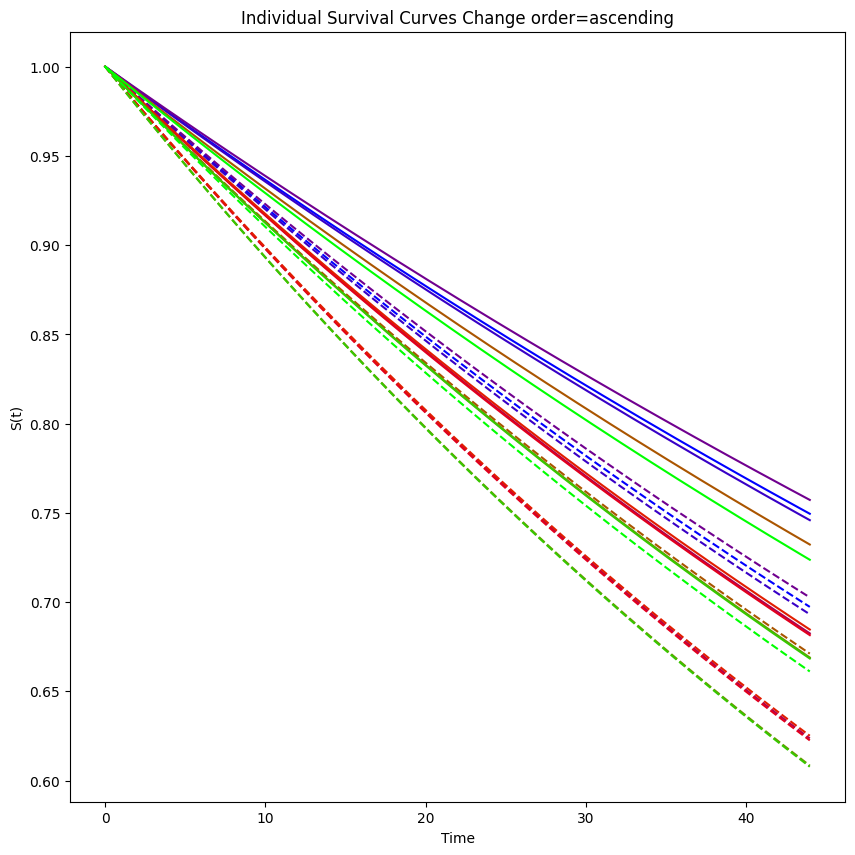

In [17]:
eps = 0.3
visualize_individual_curves_attacked(clf_robust,dataloader_train,epsilon=eps,order="descending")
visualize_individual_curves_attacked(clf_robust,dataloader_train,epsilon=eps,order="ascending",test_cases=10)

visualize_individual_curves_attacked(clf_robust,dataloader_test,epsilon=eps,order="descending")
visualize_individual_curves_attacked(clf_robust,dataloader_test,epsilon=eps,order="ascending")